<a href="https://colab.research.google.com/github/ddemyanova/cremad_test/blob/main/tflite_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Old way

In [ ]:
!pip install pydub

In [ ]:
import os
import numpy as np
import h5py
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof


KeyboardInterrupt: ignored

In [ ]:
ds,ds_info = tfds.load('crema_d', split='validation', shuffle_files=True,  with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5144 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/crema_d/1.0.0.incompleteZL9XA0/crema_d-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/738 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/crema_d/1.0.0.incompleteZL9XA0/crema_d-validation.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/1556 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/crema_d/1.0.0.incompleteZL9XA0/crema_d-test.tfrecord*...:   0%|          |…

Dataset crema_d downloaded and prepared to /root/tensorflow_datasets/crema_d/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def preprocess_audio(audio):
    spectrogram = tf.numpy_function(compute_spectrogram, [audio], tf.float32)
    spectrogram.set_shape((None, None))
    return spectrogram

def compute_spectrogram(audio):
    audio = tf.cast(audio, tf.float32)
    audio = tf.reshape(audio, [-1])
    spectrogram = tf.signal.stft(audio, frame_length=1024, frame_step=256, fft_length=1024)
    return tf.abs(spectrogram)

def preprocess_example(example):
    audio = preprocess_audio(example['audio'])
    label = example['label']
    return audio, label


In [ ]:
preprocessed_ds = ds.map(preprocess_example)


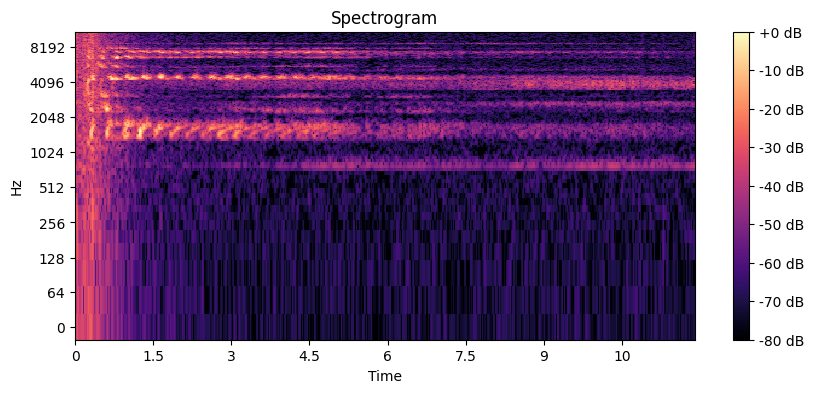

In [ ]:
sample = next(iter(preprocessed_ds))
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(sample[0].numpy(), ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

In [ ]:
test_ds = tfds.load('crema_d', split='train', shuffle_files=False, with_info=False)

In [ ]:
preprocessed_test_ds = test_ds.map(preprocess_example)

save model


In [ ]:
X_train = []
Y_train = []

max_length = 157 * 513  # Maximum length of flattened data tensor

for example in preprocessed_ds:
    data_tensor, label = example
    flattened_data = tf.reshape(data_tensor, (-1,))
    print(flattened_data.shape[0])
    padded_data = np.pad(flattened_data.numpy(), (0, max_length - flattened_data.shape[0]))
    X_train.append(padded_data)
    Y_train.append(label.numpy())

X_train = tf.convert_to_tensor(X_train)  # Convert the list to a TensorFlow tensor
Y_train = tf.convert_to_tensor(Y_train)  # Convert the list to a TensorFlow tensor

model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

model_filename = 'saved_model.joblib'
joblib.dump(model, model_filename)

116964


ValueError: ignored

# Новый раздел

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [44]:
Crema = "/content/drive/MyDrive/AudioWAV/"


In [45]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []


In [46]:
for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')



In [47]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)

label_encoder = LabelEncoder()
print(Crema_df['Emotions'])

# Crema_df.to_csv("Crema_df.csv",index=False)
# Crema_df.head()

0         angry
1         angry
2           sad
3         happy
4       disgust
         ...   
4909       fear
4910      angry
4911       fear
4912      angry
4913        sad
Name: Emotions, Length: 4914, dtype: object


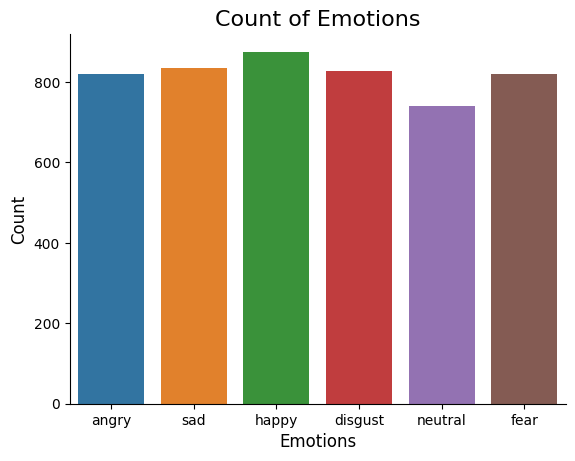

In [48]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=Crema_df, x="Emotions")

plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.show()

In [59]:
def create_waveplot(data, sr, e):
    # plt.figure(figsize=(10, 3))
    # plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    # librosa.display.waveplot(data, sr=sr)
    # plt.show()
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

/content/drive/MyDrive/AudioWAV/1072_IOM_SAD_XX.wav


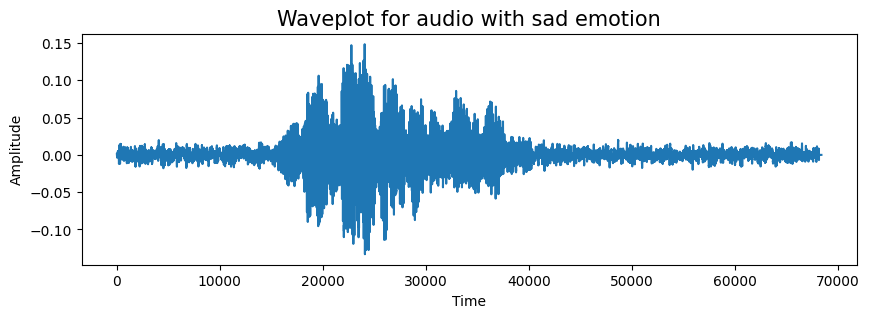

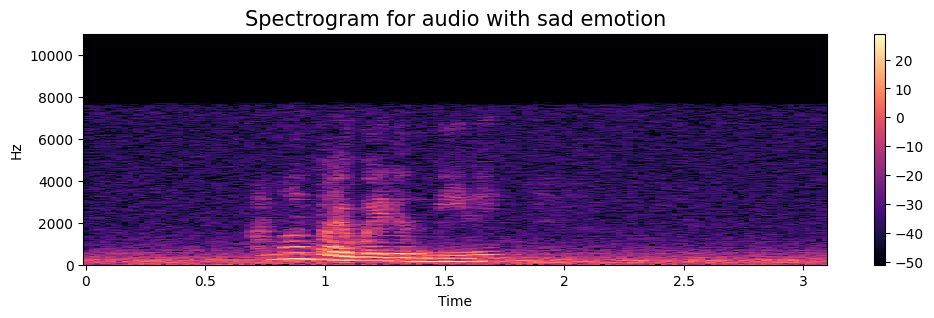

In [60]:
emotion='sad'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [74]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data,sr= sampling_rate,n_steps =pitch_factor)


In [63]:
path = np.array(Crema_df.Path)[1]
data, sample_rate = librosa.load(path)

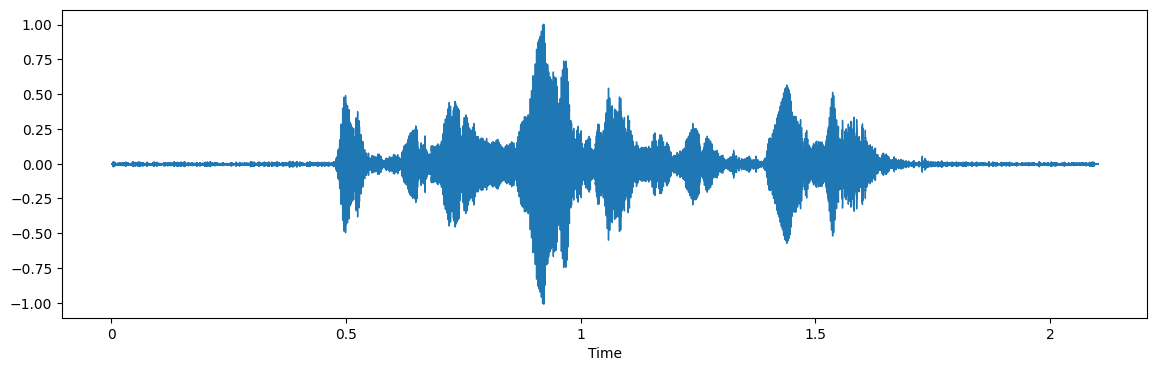

In [66]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

Noise injection

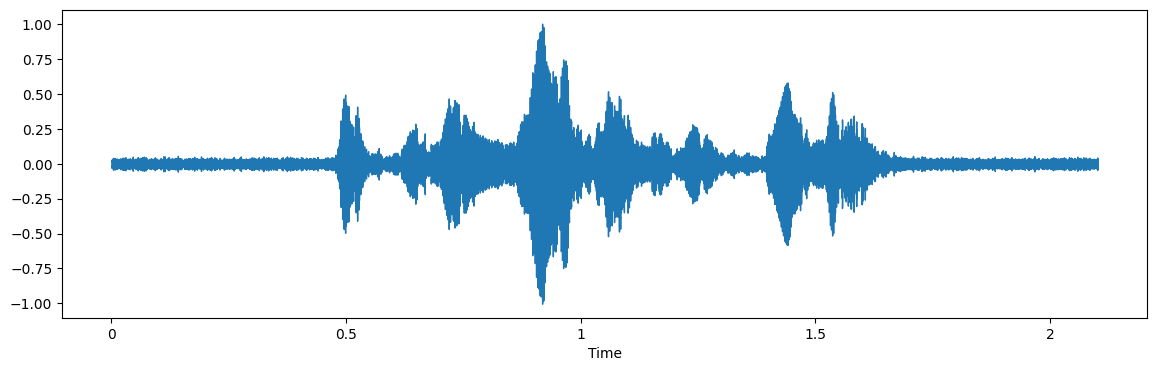

In [65]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [77]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # # data with noise
    # noise_data = noise(data)
    # res2 = extract_features(noise_data)
    # result = np.vstack((result, res2)) # stacking vertically

    # # data with stretching and pitching
    # new_data = stretch(data)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    # res3 = extract_features(data_stretch_pitch)
    # result = np.vstack((result, res3)) # stacking vertically

    return result


In [ ]:
X, Y = [], []
for path, emotion in zip(Crema_df.Path, Crema_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), Crema_df.Path.shape

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
model=Sequential()
model.add((256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

print(classification_report(y_test, y_pred))